# Preparing

## Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from utils import *
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_columns', 100)
matplotlib.rcParams.update({"font.size": 16,'lines.linewidth': 2.5})
# matplotlib.rcdefaults()

figures saved to /tmp/figures


In [2]:
DATA_DIR = '../data/'
dfj = get_df(DATA_DIR + 'pai_job_table.csv')
dft = get_df(DATA_DIR + 'pai_task_table.csv')
dfi = get_df(DATA_DIR + 'pai_instance_table.csv')
dfs = get_df(DATA_DIR + 'pai_sensor_table.csv')
dfg = get_df(DATA_DIR + 'pai_group_tag_table.csv')
dfp = get_df(DATA_DIR + 'pai_machine_spec.csv')
dfm = get_df(DATA_DIR + 'pai_machine_metric.csv')

## Join tables

`dfa`: DataFrame of Tasks

In [3]:
dfa = get_dfa(dft, dfj, dfi, dfg)
# dfa.to_csv('dfa.csv') # optional

dft + dfj ...
dft + dfj + dfi ...
dft + dfj + dfi + dfg ...


`dfw`: DataFrame of Workers

In [4]:
dfw = get_dfw(dfi, dft, dfg)
# dfw.to_csv('dfw.csv') # optional

dfi + dft ...
dfi + dft + dfg ...


`dfws`: DataFrame of Worker with sensor data

In [5]:
dfws = dfw.merge(dfp.drop(columns={'gpu_type'}), on='machine', how='left')
dfws = dfws.merge(dfs.drop(columns=['job_name','task_name','inst_id','machine']), on='worker_name')
# dfws.to_csv('dfws.csv') # optional

`dfas`: DataFrame of Task with sensor data

In [6]:
dfas = dfws.groupby(['job_name','task_name'])[['cpu_usage','gpu_wrk_util','avg_mem','avg_gpu_wrk_mem','plan_cpu','plan_gpu','plan_mem','cap_cpu','cap_gpu','cap_mem']].sum()
dfas = dfa.drop(columns=['plan_cpu','plan_mem','plan_gpu']).merge(dfas, on=['job_name','task_name'])
# dfas.to_csv('dfas.csv') # optional

# Workload Characterization

## Overview

### Figure 2: Overview of MLaaS workloads

<Figure size 480x360 with 0 Axes>

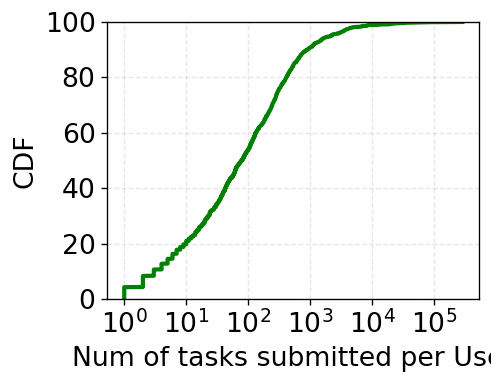

In [7]:
user_task_count = dfa.groupby('user').count()[['job_name']]

plt.figure(figsize=(4,3), dpi=120)
plot_data_cdf(user_task_count['job_name'], xlog=True,
              ylabel='CDF',xlabel='Num of tasks submitted per User',
              xticks=[1,10,100,10**3,10**4,10**5])

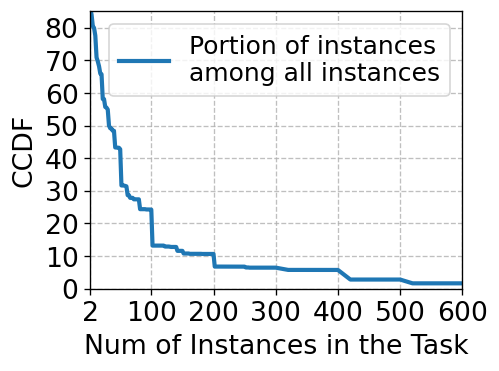

In [8]:
inst_num_list = list(range(2, 300, 2))+list(range(300, 620, 20))
inst_task_num_ratio_df = get_inst_task_num_ratio(dfa, inst_num_list) * 100

plt.figure(figsize=(4,3), dpi=120)
plt.plot(inst_task_num_ratio_df.T.num_inst_ratio, label='Portion of instances\namong all instances')
plt.grid(alpha=0.8, linestyle='--')
plt.xlabel('Num of Instances in the Task')
plt.ylabel('CCDF')
plt.xticks((2,100,200,300,400,500,600))
plt.yticks([0,10,20,30,40,50,60,70,80])
plt.xlim(2, 600)
plt.ylim(0, 85)
plt.legend(fontsize=15)

## Temporal Pattern

### Figure 3: Task submission patterns

Hour 0 Date: 1970-01-25 00:00:03+08:00


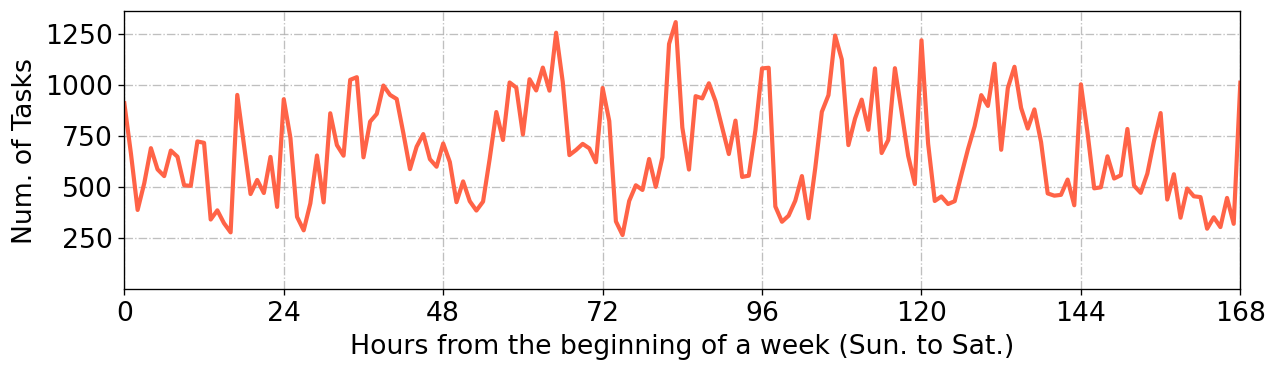

In [9]:
offset = -600
dfa['hourofyear'] = dfa.start_date.apply(lambda c: c.dayofyear * 24 + c.hour)
dftcc = dfa.groupby('hourofyear').count()[['job_name']].reset_index()
dftcc['hour'] = dftcc.hourofyear + offset
print('Hour 0 Date: {}'.format(dfa[dfa.hourofyear==-offset].start_date.min()))

plt.figure(figsize=(12,3), dpi=120)
num_days = 7
plt.plot(dftcc[(dftcc.hour>=0)&(dftcc.hour<24*num_days+1)].set_index('hour')[['job_name']], color='tomato')
plt.xlabel('Hours from the beginning of a week (Sun. to Sat.)')
plt.ylabel('Num. of Tasks')
plt.grid(alpha=0.8, linestyle='-.')
plt.xlim(0, 24*num_days)
plt.ylim(0, )
plt.yticks([250,500,750,1000,1250])
_ = plt.xticks([24 * x for x in range(num_days+1)])
# plt.savefig('/tmp/figures/{}.pdf'.format('diurnal-pattern-task'),bbox_inches='tight')

/tmp/ipykernel_17365/1452016240.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.boxplot(data=hourly_task_data_df, x='hour', y='value', whis=1, fliersize=0, palette=color_palette)


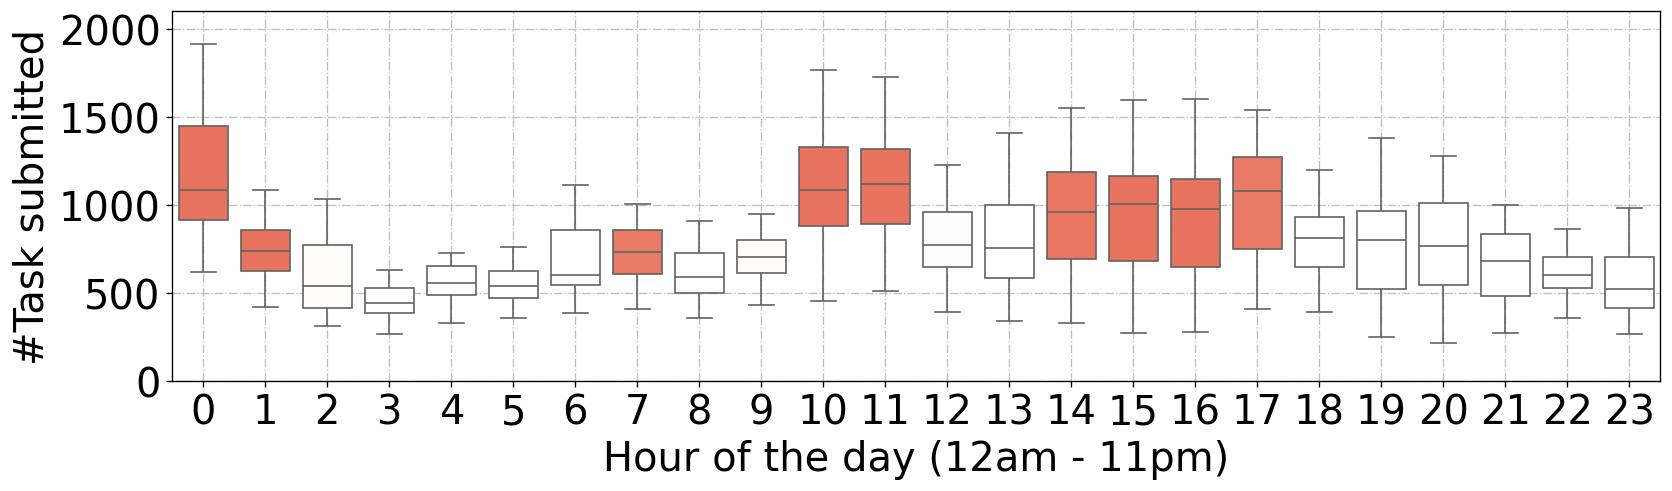

In [10]:
hourly_task = get_hourly_task_request(dfa)
hourly_task_data_df = pd.melt(hourly_task, 
    value_vars=[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])
hourly_task_data_df['hour'] = hourly_task_data_df['hour'].astype('int')

matplotlib.rcParams.update({"font.size": 24})
plt.figure(figsize=(16,4), dpi=120)
highlight_color = 'tomato'
mean_value = hourly_task_data_df.value.mean()
color_df = pd.DataFrame(hourly_task_data_df.groupby('hour').mean())
color_df['color'] = color_df.value.apply(lambda x: '1' if x < mean_value else highlight_color)
color_df['mean_value'] = mean_value
color_palette = sns.blend_palette(color_df.color.tolist(), n_colors=24)

g = sns.boxplot(data=hourly_task_data_df, x='hour', y='value', whis=1, fliersize=0, palette=color_palette)
g.set(ylim=(0, 2100))
g.set(xlabel='Hour of the day (12am - 11pm)')
g.set(ylabel='#Task submitted')
plt.yticks([0,500,1000,1500,2000])
plt.grid(alpha=0.8, linestyle='-.')
matplotlib.rcParams.update({"font.size": 16})
# plt.savefig('/tmp/figures/{}.pdf'.format('overview-task_submission_hourly'),bbox_inches='tight')

Hour 0 Date: 1970-01-25 00:00:03+08:00


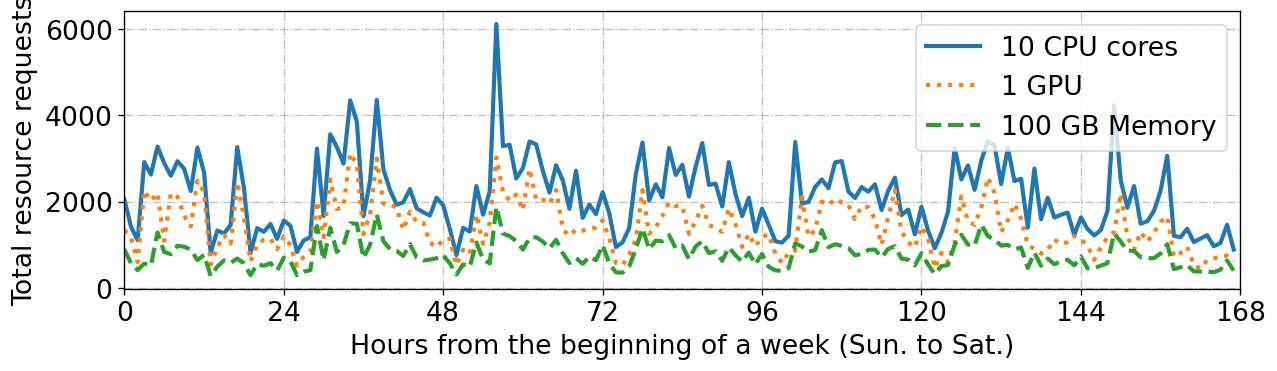

In [11]:
dfw['hourofyear'] = dfw.start_date.apply(lambda c: c.dayofyear * 24 + c.hour)
dfitcr = dfw.groupby('hourofyear')[['plan_cpu','plan_gpu','plan_mem']].sum().reset_index()
dfitcr['hour'] = dfitcr.hourofyear + offset
print('Hour 0 Date: {}'.format(dfa[dfa.hourofyear==-offset].start_date.min()))

plt.figure(figsize=(12,3), dpi=120)
num_days = 7
plt.plot(dfitcr[(dfitcr.hour>=0)&(dfitcr.hour<24*num_days)].set_index('hour')['plan_cpu']/1000, label='10 CPU cores', linestyle='solid')
plt.plot(dfitcr[(dfitcr.hour>=0)&(dfitcr.hour<24*num_days)].set_index('hour')['plan_gpu']/100, label='1 GPU', linestyle='dotted')
plt.plot(dfitcr[(dfitcr.hour>=0)&(dfitcr.hour<24*num_days)].set_index('hour')['plan_mem']/100, label='100 GB Memory', linestyle='dashed')
plt.xlabel('Hours from the beginning of a week (Sun. to Sat.)')
plt.ylabel('Total resource requests')
plt.grid(alpha=0.8, linestyle='-.')
plt.legend(ncol=1, loc='best')
plt.xlim(0, 24*num_days)
_ = plt.xticks([24 * x for x in range(num_days+1)])

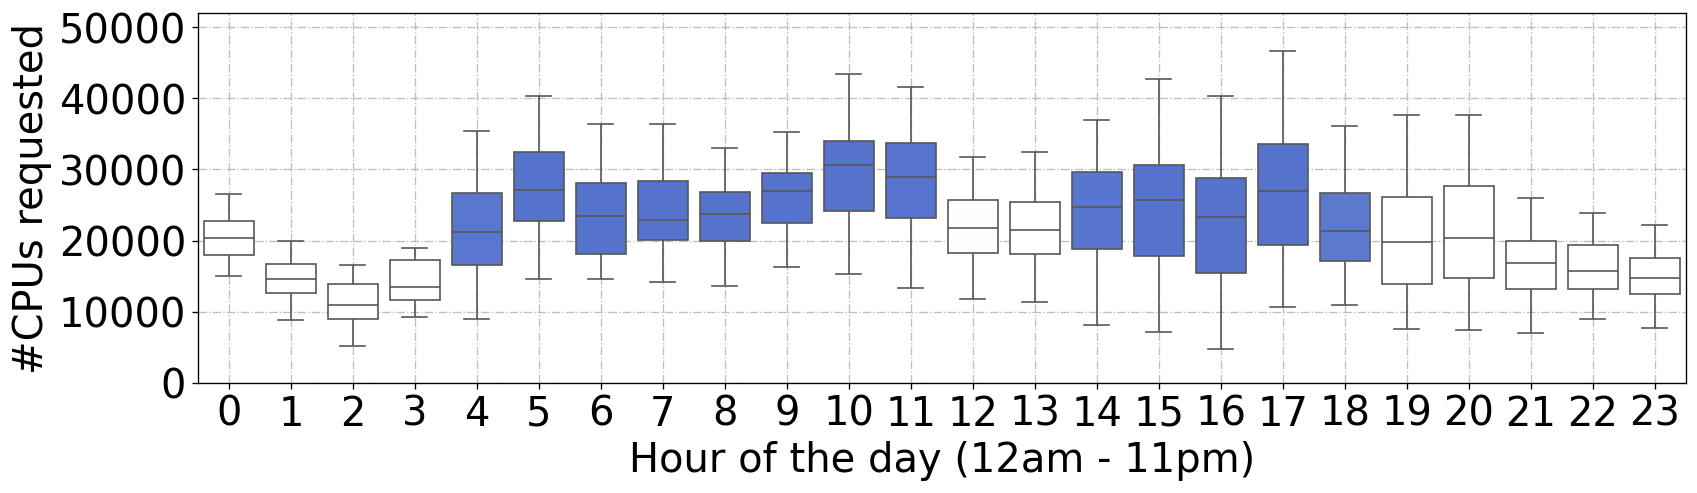

In [12]:
plan_cpu_df = get_hourly_task_resource_request(dfw.dropna(subset=['job_name']), metrics='cpu')
plan_cpu_data_df = pd.melt(plan_cpu_df, 
    value_vars=[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])
plan_cpu_data_df['hour'] = plan_cpu_data_df['hour'].astype('int')

matplotlib.rcParams.update({"font.size": 24})
plt.figure(figsize=(16,4), dpi=120)
highlight_color = 'royalblue'
mean_value = plan_cpu_data_df.value.mean()
color_df = pd.DataFrame(plan_cpu_data_df.groupby('hour').mean())
color_df['color'] = color_df.value.apply(lambda x: '1' if x < mean_value else highlight_color)
color_palette = sns.blend_palette(color_df.color.tolist(), n_colors=24)

g = sns.boxplot(data=plan_cpu_data_df, x='hour', y='value', hue='hour', whis=1, fliersize=0, palette=color_palette, legend=False, dodge=False)
g.set(ylim=(0, 52000))
g.set(xlabel='Hour of the day (12am - 11pm)')
g.set(ylabel='#CPUs requested')
plt.grid(alpha=0.8, linestyle='-.')
matplotlib.rcParams.update({"font.size": 16})
# plt.savefig('/tmp/figures/{}.pdf'.format('overview-cpu_request_hourly'),bbox_inches='tight')

### Figure 4: Task runtime and wait time

In [13]:
dfphilly = pd.read_csv('philly_runtime.csv')
# Source: https://github.com/msr-fiddle/philly-traces
# Myeongjae Jeon, et al. "Analysis of large-scale multi-tenant GPU clusters for DNN training workloads." USENIX ATC'19

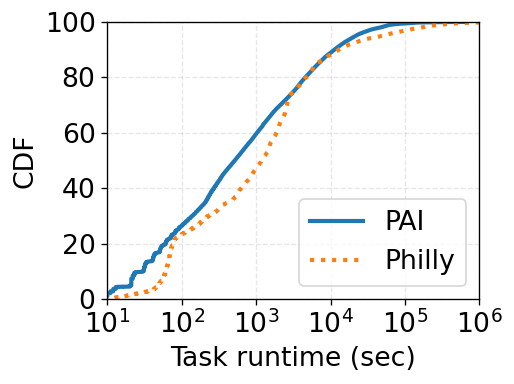

In [14]:
plot_data_cdfs([dfa.runtime_i.dropna(),dfphilly.runtime.dropna()], ['PAI','Philly'],
               xticks=[10,100,1000,10000,10**5,10**6], xlim=[10,10**6],
               xlog=True, xlabel='Task runtime (sec)', loc='lower right')

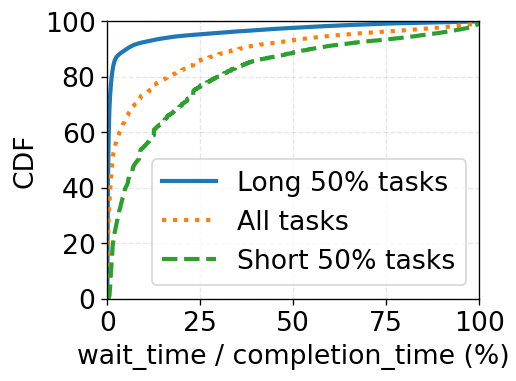

In [15]:
data_df = dfa
median_time = data_df.runtime_i.median()
data_df['wait_over_completion'] = data_df['wait_time']/data_df['runtime']
plot_data_cdfs([100*data_df[data_df.runtime_i > median_time]['wait_over_completion'].dropna(),
                100*data_df['wait_over_completion'].dropna(),
                100*data_df[data_df.runtime_i <= median_time]['wait_over_completion'].dropna()],
               ['Long 50% tasks','All tasks','Short 50% tasks'], xlim=[0,100], 
               xlabel='wait_time / completion_time (%)', figsize=(4,3))

### Figure 5: Task wait time and runtime by GPU requests

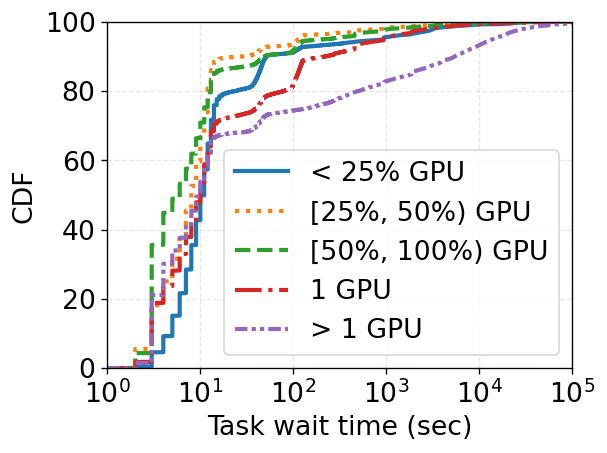

In [16]:
data_df = dfa
data = [data_df[data_df.plan_gpu < 25].wait_time.dropna(),
        data_df[(data_df.plan_gpu >= 25)&(data_df.plan_gpu < 50)].wait_time.dropna(),
        data_df[(data_df.plan_gpu >= 50)&(data_df.plan_gpu < 100)].wait_time.dropna(),
        data_df[(data_df.plan_gpu ==100)].wait_time.dropna(),
        data_df[(data_df.plan_gpu > 100)].wait_time.dropna()]
data_label = ['< 25% GPU', '[25%, 50%) GPU', '[50%, 100%) GPU', '1 GPU','> 1 GPU']
plot_data_cdfs(data, datalabel=data_label, figsize=(5,3.75), dpi=120,
               xlog=True, xticks=[1,10,100,1000,10**4,10**5], xlim=(1, 10**5), xlabel='Task wait time (sec)')

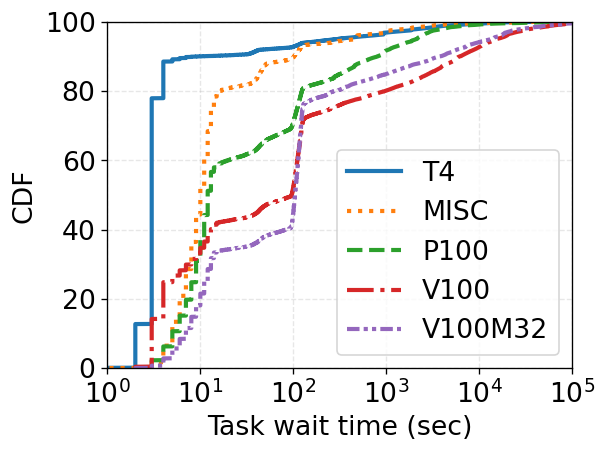

In [17]:
data_df = dfa
data = [data_df[data_df.gpu_type=='T4'].wait_time.dropna(),
        data_df[data_df.gpu_type=='MISC'].wait_time.dropna(),
        data_df[data_df.gpu_type=='P100'].wait_time.dropna(),
        data_df[data_df.gpu_type=='V100'].wait_time.dropna(),
        data_df[data_df.gpu_type=='V100M32'].wait_time.dropna(),]
data_label = ['T4', 'MISC', 'P100', 'V100', 'V100M32']
plot_data_cdfs(data, datalabel=data_label, figsize=(5,3.75), dpi=120,
               xlog=True, xticks=[1,10,100,1000,10**4,10**5], xlim=(1, 10**5), xlabel='Task wait time (sec)')

Text(0.5, 0, 'Proportion of Tasks (%)')

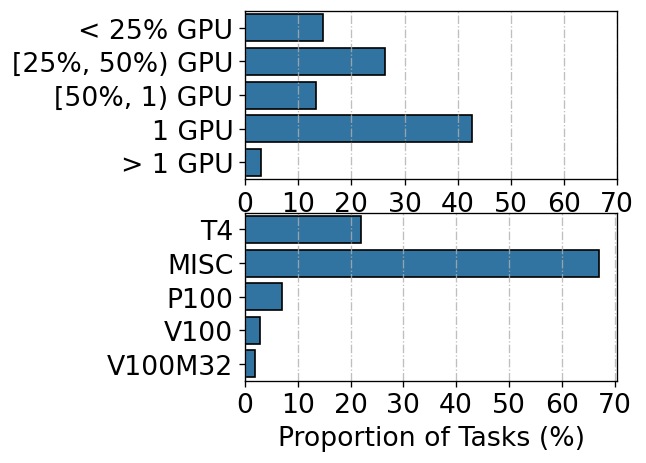

In [18]:
data_df = dfa
data = [len(data_df[data_df.plan_gpu < 25]),
        len(data_df[(data_df.plan_gpu >= 25)&(data_df.plan_gpu < 50)]), 
        len(data_df[(data_df.plan_gpu >= 50)&(data_df.plan_gpu < 100)]), 
        len(data_df[(data_df.plan_gpu ==100)]),
        len(data_df[(data_df.plan_gpu > 100)]),
        len(data_df[data_df.gpu_type=='T4']),
        len(data_df[data_df.gpu_type=='MISC']),
        len(data_df[data_df.gpu_type=='P100']),
        len(data_df[data_df.gpu_type=='V100']),
        len(data_df[data_df.gpu_type=='V100M32'])]
data_plot = [100 * i / len(data_df.plan_gpu.dropna()) for i in data]
data_label = ['< 25% GPU', '[25%, 50%) GPU', '[50%, 1) GPU', '1 GPU','> 1 GPU',
'T4','MISC','P100','V100','V100M32']

f, axes = plt.subplots(2, 1, figsize=(4, 4), sharex=False, dpi=120)
rect = sns.barplot(y=data_label[:5], x=data_plot[:5], orient='h', ax=axes[0], edgecolor='black')
axes[0].grid(alpha=0.8, linestyle='-.',axis='x')
axes[0].set_xticks(range(0, 80, 10))
sns.barplot(y=data_label[5:], x=data_plot[5:], orient='h', ax=axes[1], edgecolor='black')
axes[1].grid(alpha=0.8, linestyle='-.',axis='x')
axes[1].set_xticks(range(0, 80, 10))
plt.xlabel('Proportion of Tasks (%)')

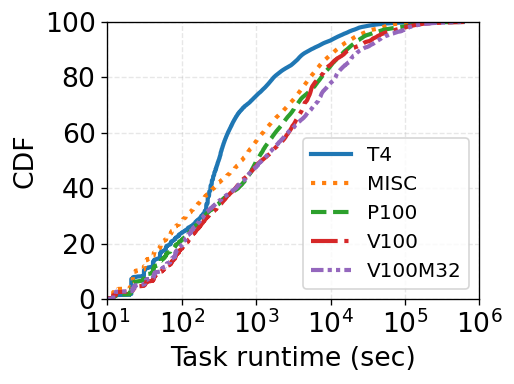

In [19]:
data_df = dfa
data_label = ['T4', 'MISC', 'P100', 'V100', 'V100M32']
data=[data_df[(data_df.gpu_type==v) & (data_df.status=='Terminated')].runtime_i.dropna() for v in data_label]
plot_data_cdfs(data, data_label, xlabel="Task runtime (sec)", 
               xticks=[10**x for x in range(1, 7)], xlog=True,
               figsize=(4,3), dpi=120, xlim=[10, 10**6], fontsize=12)

## Spatial Pattern

### Figure 6: Task resource request and usage

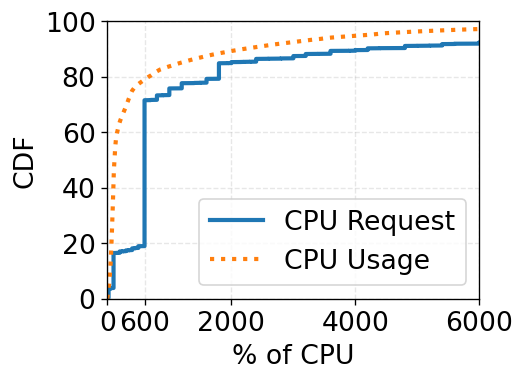

In [20]:
data_df = dfas
plot_data_cdfs([data_df['plan_cpu'].dropna(), data_df['cpu_usage'].dropna()], ['CPU Request', 'CPU Usage'],
               xlabel='% of CPU', xlim=(0, 6000), ylabel='CDF', xticks=[0,600,2000,4000,6000], dpi=120)

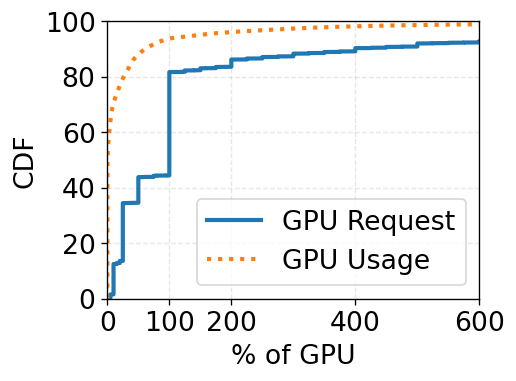

In [21]:
data_df = dfas
plot_data_cdfs([data_df['plan_gpu'].dropna(), data_df['gpu_wrk_util'].dropna()], ['GPU Request', 'GPU Usage'],
               xlabel='% of GPU', xlim=(0, 600), ylabel='CDF', xticks=[0,100,200,400,600], dpi=120,loc='lower right')

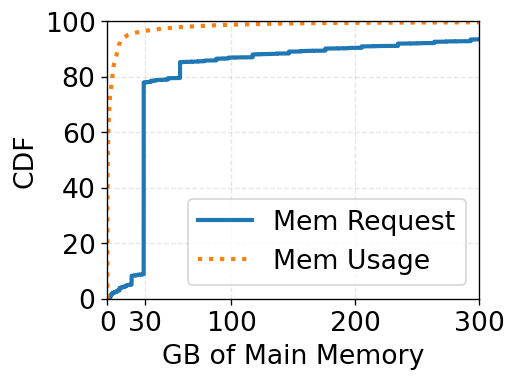

In [22]:
data_df = dfas
plot_data_cdfs([data_df['plan_mem'].dropna(), data_df['avg_gpu_wrk_mem'].dropna()], ['Mem Request', 'Mem Usage'],
               xlabel='GB of Main Memory', xlim=(0, 300), ylabel='CDF', xticks=[0,30,100,200,300], dpi=120)

In [23]:
dfa.columns

Index(['job_name', 'task_name', 'inst_num', 'status', 'start_time', 'end_time',
       'plan_cpu', 'plan_mem', 'plan_gpu', 'gpu_type', 'inst_id', 'user',
       'status_j', 'start_time_j', 'end_time_j', 'runtime', 'status_i',
       'start_time_i', 'end_time_i', 'runtime_i', 'duration_min', 'wait_time',
       'start_date', 'gpu_type_spec', 'group', 'workload', 'hourofyear',
       'wait_over_completion'],
      dtype='object')

cpu: plan > usage: 84.46%, plan < usage: 15.51%
gpu: plan > usage: 98.02%, plan < usage: 1.97%
mem: plan > usage: 95.88%, plan < usage: 4.12%


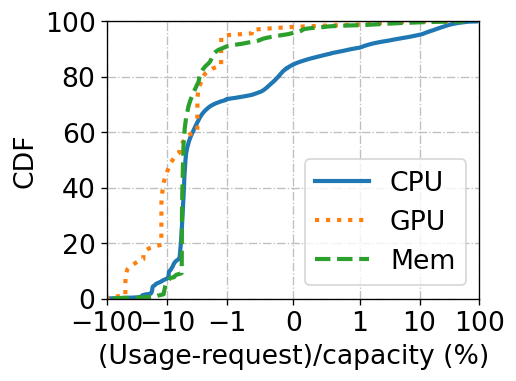

In [24]:
pgu_datas, ugp_datas, pgu_label, ugp_label = plan_minus_usg_over_cap_task(dfas)
data = [(100 * ugp_datas[i]).tolist() + (-100 * pgu_datas[i]).tolist() for i in [0,1,2]]
datalabel = ['CPU','GPU','Mem']

from matplotlib.ticker import StrMethodFormatter, NullFormatter
fig, ax = plt.subplots(dpi=120, figsize=(4,3))
for i, d in enumerate(data):
    if type(data) == pd.DataFrame:
        d.dropna(inplace=True)
    x, y = get_cdf(d)
    label = datalabel[i] if datalabel is not None else None
    ax.plot(x, y, label=label, linestyle=linestyle_list[i % len(linestyle_list)][1])
ax.set_xscale('symlog', linscale=1, linthresh=1)
ax.set_yticks([0,20,40,60,80,100])
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
ax.set_xlim([-100, 100])
ax.set_ylim([0,100])
ax.grid(alpha=0.8, linestyle='-.')
plt.ylabel('CDF')
plt.xlabel('(Usage-request)/capacity (%)')
ax.legend()

# Cluster Characteristics

## Machine resource usage

### Figure 8: Low in network input and CPU I/O wait time

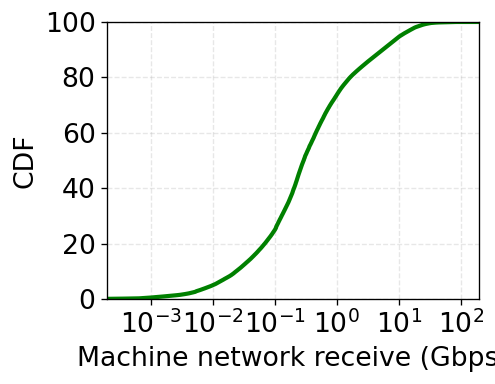

In [25]:
plot_data_cdf(8*dfws.read.dropna()/(1024**3), xlog=True, figsize=(4,3),
              xticks=[10**-3, 10**-2, 10**-1, 1, 10, 100], xlim=[2*10**-4, 200],
              xlabel='Machine network receive (Gbps)')

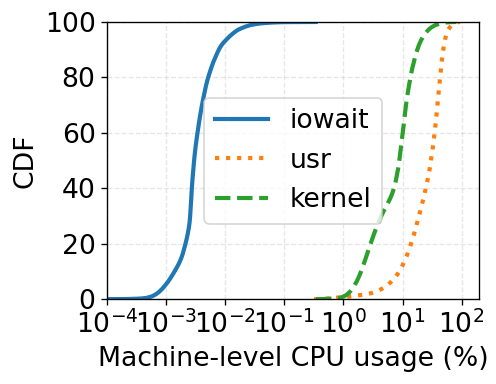

In [26]:
plot_data_cdfs([dfm[x].dropna() for x in ['machine_cpu_iowait','machine_cpu_usr','machine_cpu_kernel']],
               ['iowait','usr','kernel'], xlog=True, figsize=(4,3),
               xticks=[10**-4,10**-3, 10**-2, 10**-1, 1, 10, 100], xlim=[10**-4, 200],
               xlabel='Machine-level CPU usage (%)')